# Model

This is a reimplementation of <a href="https://www.kaggle.com/harupy/m5-baseline">this Kaggle notebook</a>.

## Set-up

In [1]:
import gc

import IPython
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
plt.rcParams['figure.figsize'] = (12, 8)
register_matplotlib_converters()

## Helper functions

In [3]:
def display(*dfs, head=False):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [4]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df


def reduce_mem_usage(df, verbose=True):
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2
        print('~> Memory usage of dataframe is {:.3f} MG'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int' or np.all(np.mod(df[col], 1) == 0):
                # Booleans mapped to integers
                if list(df[col].unique()) == [1, 0]:
                    df[col] = df[col].astype(bool)
                elif c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
             pass

    if verbose:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('~> Memory usage after optimization is: {:.3f} MG'.format(end_mem))
        print('~> Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('---' * 20)
    return df

# Load Data

In [5]:
def read_data():
    INPUT_DIR = "data"

    print("Reading files...")

    data = pd.read_csv(f"{INPUT_DIR}/processed.csv").pipe(
        reduce_mem_usage
    )

    return data

In [6]:
data = read_data()

NUM_ITEMS = 30490
DAYS_PRED = 28
day_col = "d"
dt_col = "date"

data.sample(10)

Reading files...
~> Memory usage of dataframe is 8672.315 MG
~> Memory usage after optimization is: 2274.357 MG
~> Decreased by 73.8%
------------------------------------------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,shift_t28,shift_t29,shift_t30,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_min_t7,rolling_min_t30,rolling_min_t60,rolling_max_t7,rolling_max_t30,rolling_max_t60,rolling_skew_t30,rolling_kurt_t30,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,week,day,dayofweek,is_weekend
1472663,HOBBIES_1_011_WI_3_validation,1447,3,1,9,2,1259,0,train,2014-07-10,11423,NaN,NaN,NaN,NaN,1,0,0,3.480469,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.000000e+00,2014,3,7,28,10,3,0
19571526,FOODS_3_792_CA_3_validation,1401,2,0,2,0,1852,3,train,2016-02-23,11604,NaN,NaN,NaN,NaN,0,0,0,1.000000,7.0,3.0,8.0,2.689453,2.812500,3.484375,3.021484,3.603516,3.714844,3.566406,3.699219,3.488281,5.054688,1.0,0.0,0.0,8.0,13.0,18.0,1.733398,3.357422,0.0,0.00000,0.0,0.000000e+00,2016,1,2,8,23,1,0
1375518,HOBBIES_2_110_WI_1_validation,1962,4,1,7,2,1256,0,train,2014-07-07,11423,NaN,NaN,NaN,NaN,1,1,0,5.968750,0.0,3.0,0.0,1.133789,NaN,NaN,NaN,NaN,0.428467,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.000000e+00,2014,3,7,28,7,0,0
1051919,FOODS_2_199_CA_2_validation,413,1,0,1,0,1245,0,train,2014-06-26,11421,NaN,NaN,NaN,NaN,0,0,0,NaN,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,6,26,26,3,0
11558670,FOODS_3_727_TX_3_validation,1338,2,0,6,1,1590,0,train,2015-06-06,11519,NaN,NaN,NaN,NaN,1,1,1,3.330078,0.0,0.0,0.0,3.552734,3.533203,3.179688,3.353516,2.880859,3.427734,5.265625,4.582031,3.632812,2.900391,0.0,0.0,0.0,8.0,16.0,16.0,0.915039,1.656250,0.0,0.16333,0.0,5.960464e-08,2015,2,6,23,6,5,1
9406909,FOODS_3_057_CA_2_validation,669,2,0,1,0,1519,6,train,2015-03-27,11508,NaN,NaN,NaN,NaN,0,0,0,2.880859,0.0,1.0,2.0,0.689941,0.952148,0.971680,1.143555,1.175781,0.856934,0.700195,0.733398,0.922363,0.772461,0.0,0.0,0.0,2.0,4.0,4.0,1.688477,3.570312,0.0,NaN,0.0,0.000000e+00,2015,1,3,13,27,4,0
19779957,FOODS_3_495_CA_1_validation,1107,2,0,0,0,1859,0,train,2016-03-01,11605,NaN,NaN,NaN,NaN,1,1,0,2.179688,1.0,2.0,1.0,0.689941,0.899414,1.065430,1.012695,0.899414,0.856934,0.866699,1.016602,0.911133,0.611328,0.0,0.0,0.0,2.0,3.0,4.0,0.581543,-0.771973,0.0,0.00000,0.0,0.000000e+00,2016,1,3,9,1,1,0
16344007,HOUSEHOLD_1_381_TX_3_validation,2375,5,2,6,1,1747,0,train,2015-11-10,11541,NaN,NaN,NaN,NaN,1,0,0,4.968750,0.0,0.0,0.0,0.000000,0.724121,0.636719,0.610352,0.569336,0.000000,0.399902,0.366699,0.377686,0.333252,0.0,0.0,0.0,0.0,3.0,3.0,2.126953,4.953125,0.0,0.00000,0.0,0.000000e+00,2015,4,11,46,10,1,0
5559886,HOUSEHOLD_2_447_WI_3_validation,2979,6,2,9,2,1393,0,train,2014-11-21,11442,NaN,NaN,NaN,NaN,0,0,0,1.969727,0.0,1.0,0.0,0.786621,0.728027,0.947754,0.901367,NaN,0.571289,0.433350,0.500000,0.455566,NaN,0.0,0.0,0.0,2.0,2.0,4.0,1.396484,0.492920,0.0,NaN,0.0,0.000000e+00,2014,4,11,47,21,4,0
18977302,FOODS_2_126_WI_1_validation,340,1,0,7,2,1833,0,train,2016-02-04,11601,NaN,NaN,NaN,NaN,1,0,0,4.878906,0.0,0.0,2.0,0.786621,0.730469,0.780273,0.856445,0.748535,0.571289,0.533203,0.633301,0.688965,0.438965,0.0,0.0,0.0,2.0,2.0,3.0,1.015625,-0.303223,0.0,0.00000,0.0,5.960464e-08,2016,1,2,5,4,3,0


In [7]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=40, test_days=10, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 60 * 60 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [8]:
def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)


def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [9]:
day_col = "d"
cv_params = {
    "n_splits": 3,
    "train_days": int(365 * 1.5),
    "test_days": DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

----- Fold: (1 / 3) -----


,start,end,days
train,2014-08-31,2016-02-28,547
test,2016-02-29,2016-03-27,28


----- Fold: (2 / 3) -----


,start,end,days
train,2014-09-28,2016-03-27,547
test,2016-03-28,2016-04-24,28


----- Fold: (3 / 3) -----


,start,end,days
train,2014-10-26,2016-04-24,547
test,2016-04-25,2016-05-22,28


25

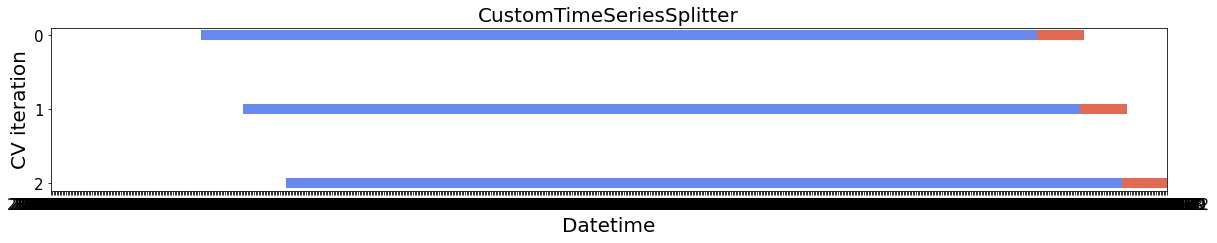

In [10]:
sample = data.iloc[::1000][[day_col, dt_col]].reset_index(drop=True)
show_cv_days(cv, sample, dt_col, day_col)
plot_cv_indices(cv, sample, dt_col)

del sample
gc.collect()

In [11]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t28",
    "shift_t29",
    "shift_t30",
    # std
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    # mean
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    # min
    "rolling_min_t7",
    "rolling_min_t30",
    "rolling_min_t60",
    # max
    "rolling_max_t7",
    "rolling_max_t30",
    "rolling_max_t60",
    # others
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
]

# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

is_train = data["d"] < 1914

# Attach "d" to X_train for cross validation.
X_train = data[is_train][[day_col] + features].reset_index(drop=True)
y_train = data[is_train]["demand"].reset_index(drop=True)
X_test = data[~is_train][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~is_train][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (21434470, 46)
X_test shape: (853720, 45)


In [12]:
X_train["item_id"] = X_train["item_id"].astype('categorical')
X_test["item_id"] = X_test["item_id"].astype('categorical')

TypeError: data type "categorical" not understood

In [ ]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(
            X_trn.drop(drop_when_train, axis=1).values.astype(np.float32),
            label=y_trn,
            categorical_feature=["item_id"],
        )
        val_set = lgb.Dataset(
            X_val.drop(drop_when_train, axis=1).values.astype(np.float32),
            label=y_val,
            categorical_feature=["item_id"],
        )

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [ ]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)

del X_train, y_train
gc.collect()

In [ ]:
data.shape[0] / 5